In [1]:
#Imports
# Enable Float64 for more stable matrix inversions.
from jax import config
import warnings
import pandas as pd
import seaborn as sns
import numpyro.distributions as npd
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(".."))
from examples.utils import (
    clean_legend,
    confidence_ellipse,
    use_mpl_style,
)

config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(123)

# set the default style for plotting
use_mpl_style()

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

c:\Users\alexp\Anaconda\envs\gpjax_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definition of GPs
**Formally GPs are defined as:**\
*"... a collection of random variables, any finite number of which have a joint Gaussian distribution." (Rasmussen and Williams 2008, p. 13)*

For our purposes of regression of some true latent function $\mathit{f}\,$ we can interpret this concretely:
1. Since in regression we are unsure of the true function values at a location $\mathit{x}$, in a probabilistic modeling fashion we can think of them as **random variables** ($\mathit{X=f(x)}$), which represents our uncertainty about the function.
2. This implies that since $\mathit{f}\,$ is typically continous, and hence can be evaluated at infinitely many different $\mathit{x}\,$ we are modeling it as a collection of infinitely many random variables. In other words, we can think of our model of $\mathit{f}\,$ as a distribution over functions. This exactly corresponds to what a GP is.
3. Since for any practical use like making predictions in regression we can only ever evaluate our function at a finite number of inputs ($\mathit{X_{eval} = \mathbf{x}_{eval}^{(1)}, \dots, \mathbf{x}_{eval}^{(m)}} | m \in \{ n \in \mathbb{N} \mid n < \infty \}$),\
 we can think of this vector $\mathbf{f(x_{eval})}\,$ as the *finite number* of random variables mentioned in the above GP definition.

Text(0.5, 1.0, 'Latent Function and Evaluations')

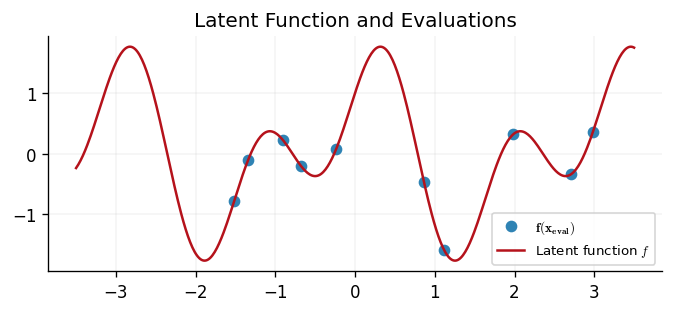

In [2]:
#Defining some example function
m = 10
noise = 0
key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(m,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

#Plot latent function and evaluations
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="$\mathbf{f(x_{eval})}$", color=cols[0])
ax.plot(xtest, ytest, label="Latent function $\mathit{f}$", color=cols[1])
ax.legend(loc="best")
ax.set_title("Latent Function and Evaluations")

4. Note, how the definition of a GP states that ***any finite number*** [of these random variables] ***have a joint Gaussian distribution***. In our interpretation this means that for any finite number of function values $\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$ is assumed. Actually, this means we are modeling the latent function (or all possible values of it) $\mathit{f}\,$ as an infinite-dimensional multivariate Gaussian, from which by the marginalisation property of multivariata Gaussians ($\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)\Rightarrow \mathit{f(x_{eval}^{(1)})} \sim \mathcal{N}(\mathit{\mu_1}, \sigma_1^2), \dots, \mathit{f(x_{eval}^{(n)})} \sim \mathcal{N}(\mathit{\mu_n}, \sigma_n^2)$) the beforementioned fact follows.

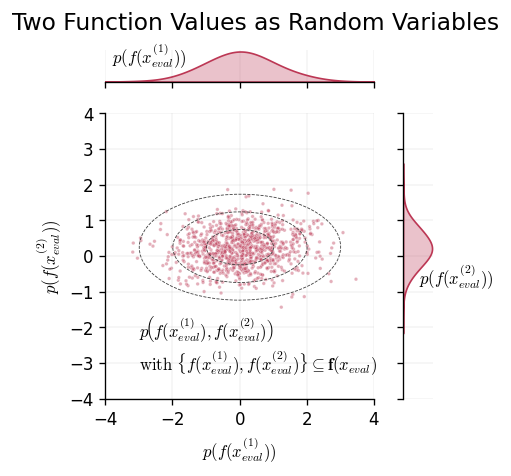

In [ ]:
#Creating example data and plot for 2 fct values as random variables with joint gaussian
n = 1000
x = npd.Normal(loc=0.0, scale=1.0).sample(key, sample_shape=(n,))
key, subkey = jr.split(key)
y = npd.Normal(loc=0.25, scale=0.5).sample(subkey, sample_shape=(n,))
key, subkey = jr.split(subkey)
xfull = npd.Normal(loc=0.0, scale=1.0).sample(subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
yfull = npd.Normal(loc=0.25, scale=0.5).sample(subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
df = pd.DataFrame({"x": x, "y": y, "idx": jnp.ones(n)})
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", cols[1]], N=256)
joint_text = (
    r"$p\!\left(f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\right)$" "\n"
    r"$\text{with } \{f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\} "
    r"\subseteq \mathbf{f}(x_{eval})$"
)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.jointplot(
        data=df,
        x="x",
        y="y",
        hue="idx",
        marker=".",
        space=0.0,
        xlim=(-4.0, 4.0),
        ylim=(-4.0, 4.0),
        height=4,
        marginal_ticks=False,
        legend=False,
        palette="inferno",
        marginal_kws={
            "fill": True,
            "linewidth": 1,
            "color": cols[1],
            "alpha": 0.3,
            "bw_adjust": 2,
            "cmap": cmap,
        },
        joint_kws={"color": cols[1], "size": 3.5, "alpha": 0.4, "cmap": cmap},
    )
    # g.ax_joint.annotate(text=r"$p(\mathit{f(x_{eval}^{(1)})}, \mathit{f(x_{eval}^{(2)})})| {\mathit{f(x_{eval}^{(1)})}, \mathit{f(x_{eval}^{(2)})}} \subseteq \mathbf{f(x_{eval})}$", xy=(-3.9, -2.0))
    g.ax_joint.annotate(text=joint_text, xy=(-3.0, -3.2))
    g.ax_marg_x.annotate(text=r"$p(\mathit{f(x_{eval}^{(1)})})$", xy=(-3.8, 0.225))
    g.ax_marg_y.annotate(text=r"$p(\mathit{f(x_{eval}^{(2)})})$", xy=(0.4, -0.78))

    g.ax_joint.set_xlabel("$p(\mathit{f(x_{eval}^{(1)})})$")
    g.ax_joint.set_ylabel("$p(\mathit{f(x_{eval}^{(2)})})$")
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=1.0,
        linestyle="--",
        linewidth=0.5,
    )
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=2.0,
        linestyle="--",
        linewidth=0.5,
    )
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=3.0,
        linestyle="--",
        linewidth=0.5,
    )
    g.figure.suptitle("Two Function Values as Random Variables", fontsize=14)
    g.figure.tight_layout()
    g.figure.subplots_adjust(top=0.9)

So now that we understand how all function values have a joint Gaussian distribution, this naturally begs the question what defines the properties of this joint Gaussian?

For this we must first note that a multivariate Gaussian of the form:

$ f(X) = c \cdot \exp\left( -\frac{1}{2}(X - \tilde{\mu})' \Sigma^{-1} (X - \tilde{\mu}) \right)$

is defined by its mean vector $\tilde{\mu} \text{(or just } \mu)$ and covariance matrix $\Sigma$. *(Mathai and Haubold 2017, p. 234)*\
We commonly write this as $\mathit{\overline{\underline{\mathrm{X}}}=f(x)} \sim \mathcal{N}(\mathit{\mu}, \Sigma)$.

So if we look at the GP as being such a multivariate Gaussian (for any finite vector of function values) the key question is how should we define it's parameters? Since it is very common to just assume a mean of 0, let us focus on the role of the covariance matrix in GPs.

To get an intuition for this, notice that because a GP is a joint distribution like $\left( f(\mathbf{x}_1), f(\mathbf{x}_2), \dots, f(\mathbf{x}_n) \right) \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma),$ when looking at the covariance between two components $\{f(\mathbf{x}_1), f(\mathbf{x}_2)\}$ with $\Sigma_{1,2}(small)$ this has to be the same, regardless of if we consider a larger set of variables like $\{f(\mathbf{x}_1), f(\mathbf{x}_2), ..., f(\mathbf{x}_n)\}$ with $\Sigma_{1,2}(large)=\Sigma_{1,2}(small)$. (Rassmussen and Williams 2008, p. 13)

This implies that there must be some consistent rule for computing the entries of the joint covariance matrix $\Sigma$ which correctly describes a valid corvariance of two function values $f(x), f(x')$. This means this rule must fullfill some properties like\
$cov(f(x),f(x'))=cov(f(x'),f(x))$ (**symmetry**) and because variance cannot be negative it must be **positive semi definite**.
Because we need covariances of function values, but the true function f is often unknown and may require a large or infinite set of basis functions to be represented as a feature transformation $\phi(x)$, it is fortunate that in GPs we can make use of the so called kernel trick. This allows that for some special functions called kernel functions (k) we can compute their operation on two vectors x and x' in the transformed space (with f(x),f(x')) in the original space using the two input vectors, written as $k(x,x')$. If such a kernel function satisfies the two requirements stated above, it is a valid covariance function (although the terms kernel and covariance function are often used interchangably) which means we can use it to compute the entries of the covariance matrix of our GP prior ($\Sigma$) based the inputs only.

With this and the convention of setting the mean to 0, we can specify any multivariate Gaussian representing a finite subset of function values represented in our GP like:

$\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}=0, \Sigma)\Rightarrow \mathit{f(x_{eval}^{(1)})} \sim \mathcal{N}(\mathit{\mu_1}=0, \sigma_1^2=k(x^{1},x^{1})), \dots, \mathit{f(x_{eval}^{(n)})} \sim \mathcal{N}(\mathit{\mu_n}=0, \sigma_n^2=k(x^{n},x^{n}))$

and equivalently:\
$\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}=0, \Sigma)\Rightarrow \mathit{\{f(x_{eval}^{(1)}),f(x_{eval}^{(2)})\}} \sim \mathcal{N}(\mathit{\mu_{1,2}}=0, \Sigma_{1,2})$ 
with

$\Sigma_{1,2} = \begin{pmatrix} K_{11} & K_{12} \\ K_{21} & K_{22} \end{pmatrix}
=\begin{pmatrix}k(x^{(1)}, x^{(1)}) & k(x^{(1)}, x^{(2)}) \\k(x^{(2)}, x^{(1)}) & k(x^{(2)}, x^{(2)})\end{pmatrix}.$

This directly leads us to the general notation of a GP:\
$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$

With this we built some intuition of how a GP represents function values in the form of a multivariate Gaussian and how we specify such a Gaussian. However, we want to improve this model by fitting it with some observations. The mechanism by which we update our generally constructed distribution using data is an application of Bayes' theorem called Bayesian (or in our case Gaussian) Inference.


### Gaussian Inference

As mentioned, in Bayesian Inference we update some initial guess about a distribution (the prior distribution), using some data by applying Bayes' theorem.

$\text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{marginal likelihood}}$

If all distributions are Gaussians, this is often called Gaussian Inference. 

#### 1. Prior

For our GP with inputs for some training points as $X$ (for which we have observations $y=f(x)+\epsilon$ where the noise is assumed as $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$) and inputs for test points $X_*$ (at which we want to later predict function values $f_*$) the prior is defined as:

$\begin{bmatrix}
\mathbf{y} \\\mathbf{f}_*\end{bmatrix}\sim \mathcal{N} \left( \mathbf{0}, \begin{bmatrix}K(X, X) + \sigma_n^2 I & K(X, X_*) \\K(X_*, X) & K(X_*, X_*)
\end{bmatrix}\right)$

Notice, that we use the $m(x)=0$ convention and assume the above mentioned noise-variance as $\sigma^2$ the prior is entirely defined by the choice of kernel function.

In [2]:
# Example Dataset with same latent function as shown in beginning
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1) #sample grid
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x) #Latent function f definition
signal = f(x) #compute function values at points x = observations
y = signal + jr.normal(subkey, shape=signal.shape) * noise #observations with noise

D = gpx.Dataset(X=x, y=y)
#test sets
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [3]:
#Defining the prior
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero() 
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel) 

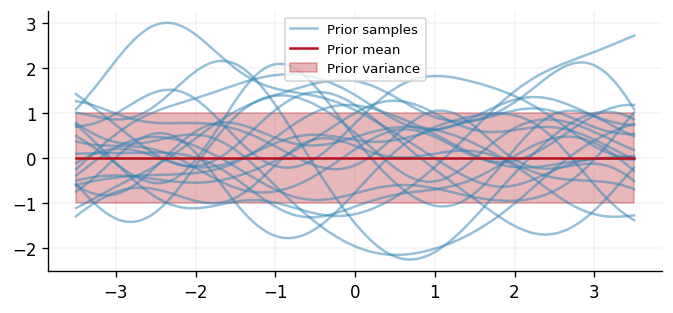

In [4]:
#creates prior distribution defined by prior covariance and mean functions
prior_dist = prior.predict(xtest, return_covariance_type="dense") #constructs the prior distribution only on the test points X_* as a Gaussian Distribution object


prior_mean = prior_dist.mean
prior_std = prior_dist.variance
samples = prior_dist.sample(key=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

#### 2. Constructing the Posterior

Theoretically, we are now constructing the posterior by applying the above shown Bayes' theorem. But because we are dealing with the special case where all terms are Gaussian, there exists an analytical solution we can plug the terms from the prior into directly without explictly defining each term in Bayes' theorem. This is called a conjugate posterior. The closed form solution for the posterior (marginalized over the function values at the test points $f_*$) follows with:

Predictive Distribution:\
$f_* \mid X, \mathbf{y}, X_* \sim \mathcal{N}(\bar{f}_*, \, \mathrm{cov}(f_*))$

Predictive Mean:\
$\bar{f}_* \triangleq \mathbb{E}[f_* \mid X, \mathbf{y}, X_*] = K(X_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} \mathbf{y}$

Predictive Covariance:\
$\mathrm{cov}(f_*) = K(X_*, X_*) - K(X_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} K(X, X_*)$

(Rasmussen and Williams 2008, p. 16)

In [ ]:
#Defining likelihood and constructing posterior
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n) #Defining a Gaussian likelihood
posterior = prior * likelihood #not a literal multiplication but the __mul__ operation defined in gpx.gps.prior...
                                #recognizes prior and likelihood are Gaussian types and directly uses analytical solution formulas...
                                # does not require manual specification/ computation of marginal likelihood

##### Hyperparameters

Earlier we noticed that the prior is specified entirely by the choice of kernel function. However, to be exact this includes the choice of kernel family (type of kernel function like e.g. linear, periodic, squared exponential, ...) and the specific kernel function in that family which is determined by a set of parameters. For example we may want to pick a kernel function from the Radial Basis Function (RBF) family given by:

$$k(x, x') = \sigma_k^2 \exp\left(-\frac{\lVert x - x' \rVert_2^2}{2 \ell^2}\right).$$

As we can see this function depends on the hyperparameters **$\sigma_k$** and **$\ell$**. Furthermore, earlier we had to define a noise-variance **$\sigma^2$** which is also a hyperparameter of the prior. We must define some initial choice for these hyperparameters, but afterwards we can optimize for them, by constructing a function which measures how well our model of the function describes the data. Generally this is what a likelihood does, which we can think of as taking our assumed distribution of the data (e.g. Gaussian) and then plugging in the data we have to obtain a function of the parameters of the distribution (if we evaluate this for a set of parameters we get a score how well the resulting distribution represents the data). Here, this is done by integrating out the unknown true function values from the prior times the likelihood:

$\begin{equation}
p(\mathbf{y} \mid X) = \int p(\mathbf{y} \mid \mathbf{f}, X) \, p(\mathbf{f} \mid X) \, d\mathbf{f}.
\end{equation}$

Because in our case both the prior and the likelihood are Gaussians, this has a closed form solution and is called the marginal likelihood. For numerical stability the log-marginal likelihood is used for optimization:\
$\begin{equation}\log p(\mathbf{y} \mid X) = -\frac{1}{2} \mathbf{y}^\top (K + \sigma_n^2 I)^{-1} \mathbf{y}- \frac{1}{2} \log \lvert K + \sigma_n^2 I \rvert - \frac{n}{2} \log 2\pi.
\end{equation}$

With this we can perform a Maximum Likelihood Estimation (MLE) of our free hyperparameters by maximizing the log-marginal likelihood. Typically, gradient based optimization methods are used for this. Using the optimized hyperparameters we obtain the optimal posterior.\
(Rasmussen and Williams 2008, pp. 18-19)

*Note, that this could have been done directly after defining the prior. The reason we do this on the posterior is purely an implementation choice with GPjax.*

In [ ]:
#MLE for hyperparameters
print("Optimization Results for Hyperparameters:")
print("Log Marginal Likelihood of posterior with pre-optimization hyperparameters:",-gpx.objectives.conjugate_mll(posterior, D))
opt_posterior, history = gpx.fit_scipy( 
    model=posterior, #hyperparameters are stored inside the posterior itself
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d), #optimization objective is the log marginal likelihood for our conjugate posterior case
    train_data=D, #dataset with technically xtrain and ytrain because ytest would be unknown
    trainable=gpx.parameters.Parameter, #this directly operates on the hyperparameters of kernel and noise and the returned object is the posterior with the optimized hyperparams
)
print("Log Marginal Likelihood of posterior with post-optimization hyperparameters:",-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization Results for Hyperparameters:
Log Marginal Likelihood of posterior with pre-optimization hyperparameters: 132.6462594200374
Optimization terminated successfully.
         Current function value: 55.469226
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19
Log Marginal Likelihood of posterior with post-optimization hyperparameters: 55.469226471183745


Using the optimized hyperparameters in posterior we can use the above given equations to make predictions at the test points $X_*$. The predictive mean will be the predicted function value $f*$ and the predictive covariance will reflect the certainty of the GP about the function values.

In [9]:
#computing predictive distribution
latent_dist = opt_posterior.predict(xtest, train_data=D, return_covariance_type="diagonal") #predictive distribution for f_* shown through eqns above
predictive_dist = opt_posterior.likelihood(latent_dist) #mean stays that of f_* and cov becomes cov(f_*) + cov(σ^2)
                                                        #-> predictive dist for noisy "observations" we could compare with some observations if we did a train_test_split

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

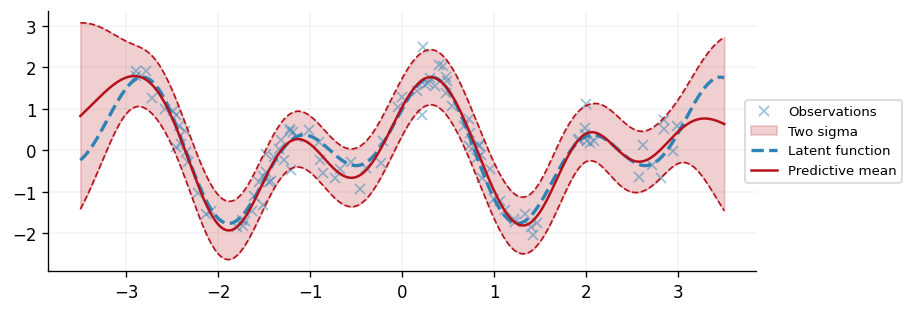

In [10]:
#Plot GP predictive distribution WITH ADDED NOISE VARIANCE
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))


*Note:
While the computational scheme is founded in probability theory like e.g. Gaussian Inference following the process described in Bayes' theorem, when substituting the actual terms these probabilistic rules concretely manifest in the form of linear algebra. Especially for the case of Gaussian Inference we concern ourselvs with here, there exist analytical solutions (due to the algebraic properties of Gaussians) to certain equations like e.g. Bayes' theorem, which means computations like for example $prior * likelihood$ are not actually shown in detail and the relevant components are directly plugged into the known analytical solution.\
For example in the posterior of a GP for noisy observations, instead of showing the full formulation for prior and likelihood and performing Gaussian Inference, they show the prior and then the posterior obtained by plugging the components of the prior into the known analytical solution without showing the likelihood specifically. But crucially under the hood this is just Gaussian inference. Here we see the likelihood as the addition of the term $\sigma ^2 I$:*

$\begin{equation}
    f_* \mid X, \mathbf{y}, X_* \sim \mathcal{N}(\bar{f}_*, \, \operatorname{cov}(f_*))
    \quad
\end{equation}$

$\begin{equation}
    \operatorname{cov}(f_*) 
    = K(X_*, X_*) 
    - K(X_*, X)\big[K(X, X) + \sigma_n^2 I\big]^{-1} K(X, X_*).
\end{equation}$

(Rasmussen and Williams 2008, p. 16)